# Second Term Project: TREC Collection

“The U.S. National Institute of Standards and Technology (NIST) has run a large IR test bed evaluation series since 1992. [...] TRECs 6–8 provide 150 information needs over about 528,000 newswire and Foreign Broadcast Information Service articles. [...] Because the test document collections are so large, there are no exhaustive relevance judgments.” [1, Section 8.2]

Your tasks, reviewed by your colleagues and the course instructors, are the following:

1.   *Implement a supervised ranked retrieval system*, [1, Chapter 15] which will produce a list of documents from the TREC collection in a descending order of relevance to a query from the TREC collection. You SHOULD use training and validation relevance judgements from the TREC collection in your information retrieval system. Test judgements MUST only be used for the evaluation of your information retrieval system.

2.   *Document your code* in accordance with [PEP 257](https://www.python.org/dev/peps/pep-0257/), ideally using [the NumPy style guide](https://numpydoc.readthedocs.io/en/latest/format.html#docstring-standard) as seen in the code from exercises.  
     *Stick to a consistent coding style* in accordance with [PEP 8](https://www.python.org/dev/peps/pep-0008/).

3.   *Reach at least 13.5% mean average precision* [1, Section 8.4] with your system on the TREC collection. You are encouraged to use techniques for tokenization, [1, Section 2.2] document representation [1, Section 6.4], tolerant retrieval [1, Chapter 3], relevance feedback, query expansion, [1, Chapter 9], learning to rank [1, Chapter 15], and others discussed in the course.

4.   _[Upload an .ipynb file](https://is.muni.cz/help/komunikace/spravcesouboru#k_ss_1) with this Jupyter notebook to the homework vault in IS MU._ You MAY also include a brief description of your information retrieval system and a link to an external service such as [Google Colaboratory](https://colab.research.google.com/), [DeepNote](https://deepnote.com/), or [JupyterHub](https://iirhub.cloud.e-infra.cz/).

[1] Manning, Christopher D., Prabhakar Raghavan, and Hinrich Schütze. [*Introduction to information retrieval*](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf). Cambridge university press, 2008.

## Loading the TREC collection

First, we will install [our library](https://gitlab.fi.muni.cz/xstefan3/pv211-utils) and load the TREC collection. If you are interested, you can take a peek at [how we preprocessed the raw TREC collection](https://drive.google.com/file/d/1neS56eHB85aowA7DraaFJL7bB-j0MK3U/view) to the final dataset that we will be using.

In [ ]:
%%capture
! pip install git+https://github.com/MIR-MU/pv211-utils.git
! pip install gensim==3.6.0

### Loading the documents

Next, we will define a class named `Document` that will represent a preprocessed document from the TREC collection. Tokenization and preprocessing of the `body` attribute of the individual documents is left to your imagination and craftsmanship.

In [ ]:
from pv211_utils.trec.entities import TrecDocumentBase

class Document(TrecDocumentBase):
    """
    A preprocessed TREC collection document.

    Parameters
    ----------
    document_id : str
        A unique identifier of the document.
    body : str
        The abstract of the document.

    """
    def __init__(self, document_id: str, body: str):
        super().__init__(document_id, body)

We will load documents into the `documents` [ordered dictionary](https://docs.python.org/3.8/library/collections.html#collections.OrderedDict). Each document is an instance of the `Document` class that we have just defined.

In [ ]:
from pv211_utils.trec.loader import load_documents

documents = load_documents(Document, cache_download='/var/tmp/pv211/trec_documents.json.gz')

In [ ]:
print('\n'.join(repr(document) for document in list(documents.values())[:3]))
print('...')
print('\n'.join(repr(document) for document in list(documents.values())[-3:]))

In [ ]:
document = documents['FT911-3']
document

In [ ]:
print(document.body)

### Loading the queries
Next, we will define a class named `Query` that will represent a preprocessed query from the TREC collection. Tokenization and preprocessing of the `body` attribute of the individual queries as well as the creative use of the `title` and `narrative` attributes is left to your imagination and craftsmanship.

In [ ]:
from pv211_utils.trec.entities import TrecQueryBase

class Query(TrecQueryBase):
    """
    A preprocessed TREC collection query.

    Parameters
    ----------
    query_id : int
        Up to three words that best describe the query.
    title : str
        Up to three words that best describe the query.
    body : str
        A one-sentence description of the topic area.
    narrative : str
        A concise description of what makes a document relevant.

    """
    def __init__(self, query_id: int, title: str, body: str, narrative: str):
        super().__init__(query_id, title, body, narrative)

We will load queries into the `train_queries` and `validation_queries` [ordered dictionaries](https://docs.python.org/3.8/library/collections.html#collections.OrderedDict). Each query is an instance of the `Query` class that we have just defined. You should use `train_queries`, `validation_queries`, and *relevance judgements* (see the next section) for training your supervised information retrieval system.



If you are training just a single machine learning model without any early stopping or hyperparameter optimization, you can use `bigger_train_queries` as the input.

If you are training a single machine learning model with early stopping or hyperparameter optimization, you can use `train_queries` for training your model and `validation_queries` to stop early or to select the optimal hyperparameters for your model. You can then use `bigger_train_queries` to train the model with the best number of epochs or the best hyperparameters.

If you are training many machine learning models with early stopping or hyperparameter optimization, then you can split your train judgements to smaller training and validation sets. Then, you can use `smaller_train_queries` for training your models, `smaller_validation_queries` to stop early or to select the optimal hyperparameters for your models, and `validation_queries` to select the best model. You can then use `bigger_train_queries` to train the best model with the best number of epochs or the best hyperparameters.


 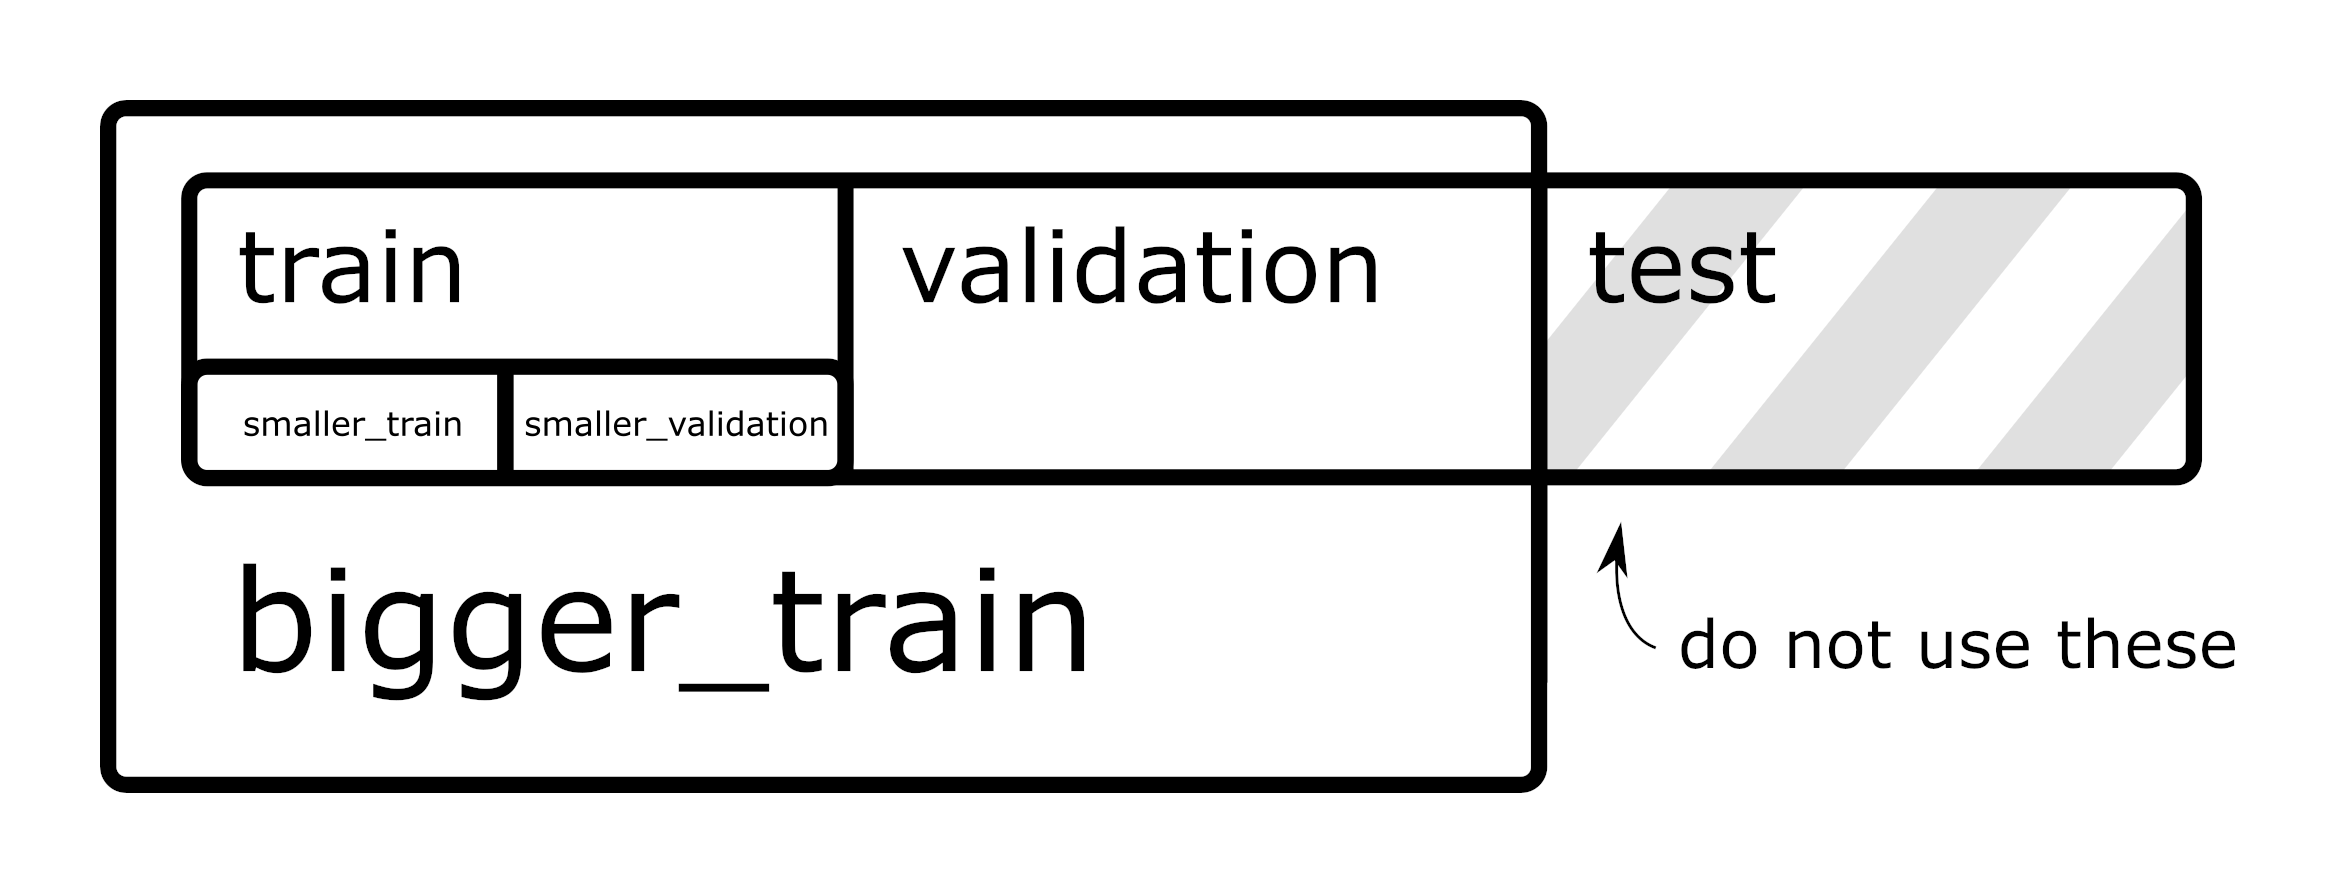

In [ ]:
from collections import OrderedDict
from itertools import chain

from pv211_utils.trec.loader import load_queries

train_queries = load_queries(Query, 'train')
validation_queries = load_queries(Query, 'validation')

bigger_train_queries = OrderedDict(chain(train_queries.items(), validation_queries.items()))

pivot = int(len(train_queries) * 0.8)
smaller_train_queries = OrderedDict(sorted(train_queries.items())[:pivot])
smaller_validation_queries = OrderedDict(sorted(train_queries.items())[pivot:])

In [ ]:
print('\n'.join(repr(query) for query in list(train_queries.values())[:3]))
print('...')
print('\n'.join(repr(query) for query in list(train_queries.values())[-3:]))

In [ ]:
query = train_queries[301]
query

In [ ]:
print(query.title)

In [ ]:
print(query.body)

In [ ]:
print(query.narrative)

### Loading the relevance judgements
Next, we will load train and validation relevance judgements into the `train_judgements` and `validation_judgement` sets. Relevance judgements specify, which documents are relevant to which queries. You should use relevance judgements for training your supervised information retrieval system.


If you are training just a single machine learning model without any early stopping or hyperparameter optimization, you can use `bigger_train_judgements` as the input.

If you are training a single machine learning model with early stopping or hyperparameter optimization, you can use `train_judgements` for training your model and `validation_judgements` to stop early or to select the optimal hyperparameters for your model. You can then use `bigger_train_judgements` to train the model with the best number of epochs or the best hyperparameters.

If you are training many machine learning models with early stopping or hyperparameter optimization, then you can split your train judgements to smaller training and validation sets. Then, you can use `smaller_train_judgements` for training your models, `smaller_validation_judgements` to stop early or to select the optimal hyperparameters for your models, and `validation_judgements` to select the best model. You can then use `bigger_train_judgements` to train the best model with the best number of epochs or the best hyperparameters.


 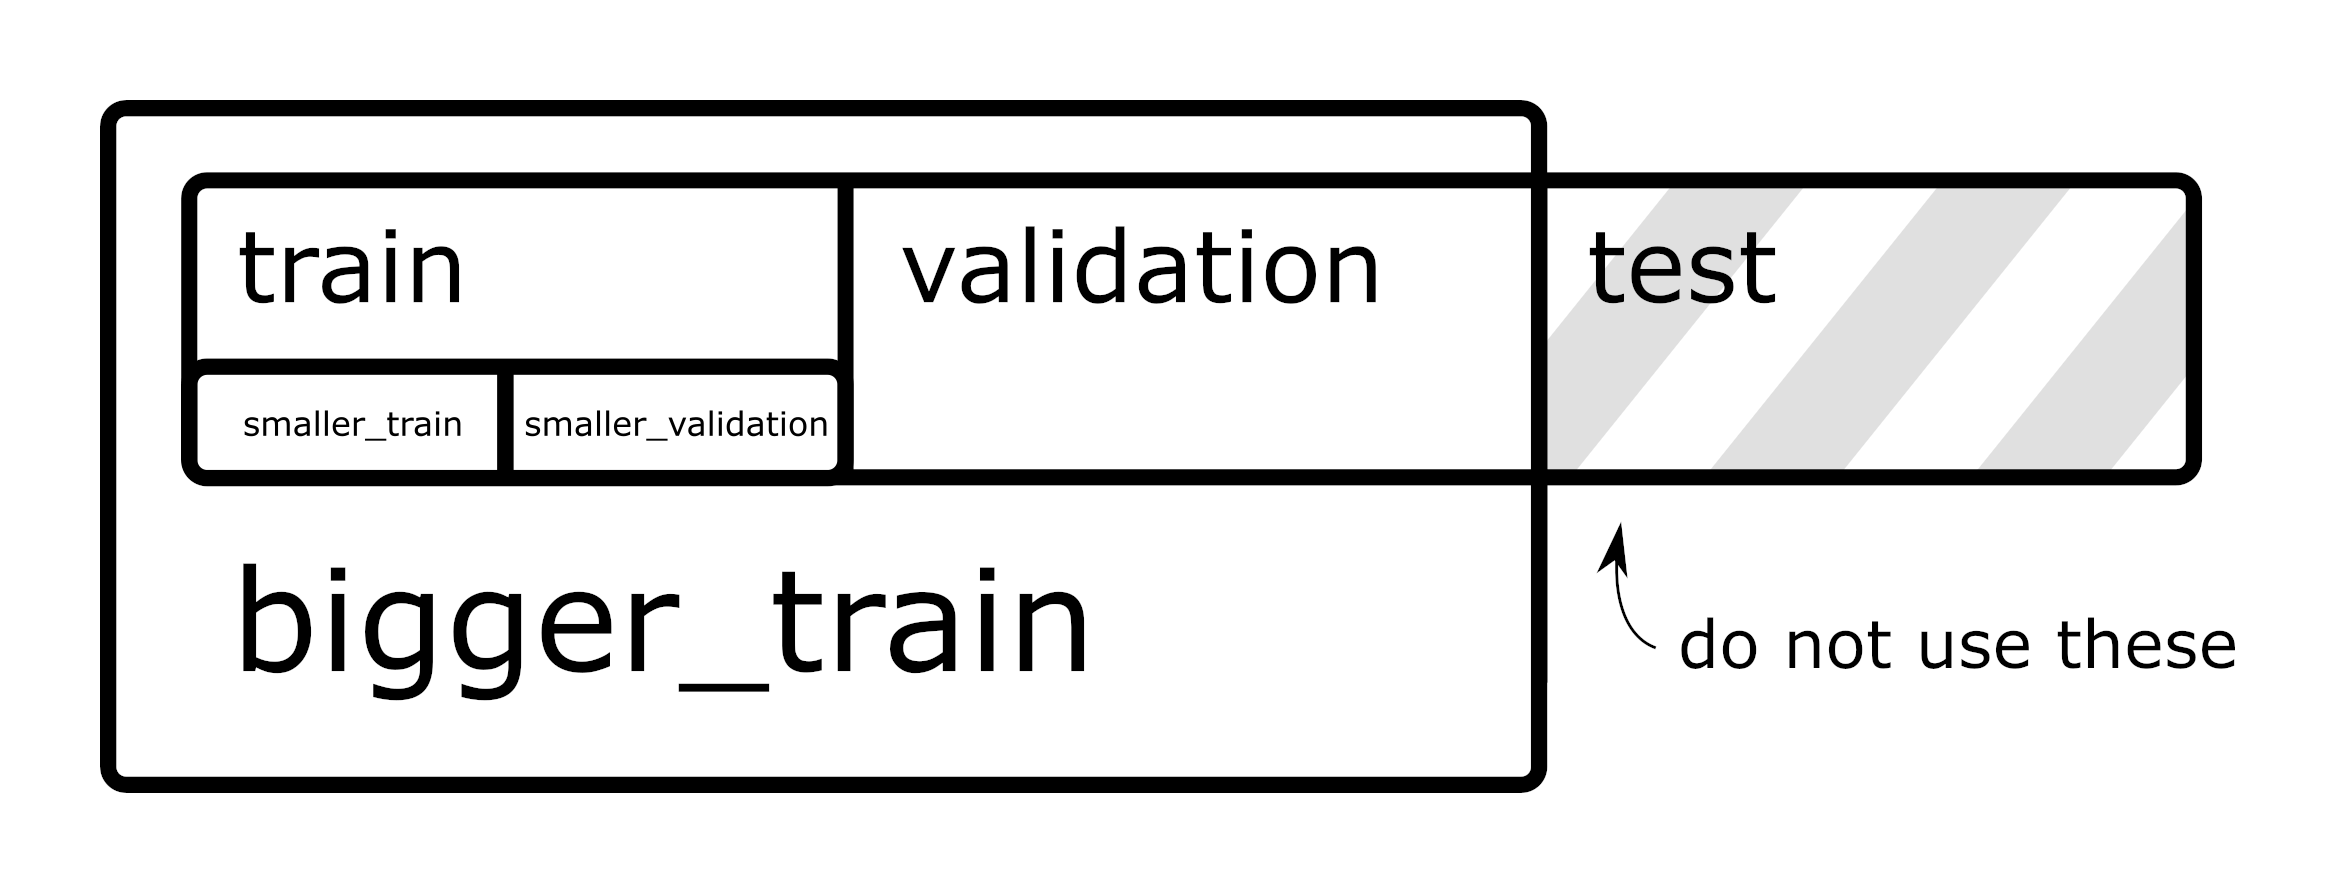

In [ ]:
from pv211_utils.trec.loader import load_judgements

train_judgements = load_judgements(train_queries, documents, 'train')
validation_judgements = load_judgements(validation_queries, documents, 'validation')

bigger_train_judgements = train_judgements | validation_judgements

pivot = int(len(train_judgements) * 0.8)
smaller_train_judgements = set(sorted(train_judgements)[:pivot])
smaller_validation_judgements = set(sorted(train_judgements)[pivot:])

In [ ]:
query = train_queries[301]
relevant_document = documents['FBIS3-10937']
irrelevant_document = documents['FBIS3-10634']

In [ ]:
query

In [ ]:
relevant_document

In [ ]:
irrelevant_document

In [ ]:
(query, relevant_document) in train_judgements

In [ ]:
(query, irrelevant_document) in train_judgements

## Implementation of your information retrieval system
Next, we will define a class named `IRSystem` that will represent your information retrieval system. Your class must define a method name `search` that takes a query and returns documents in descending order of relevance to the query.

The example implementation returns documents in decreasing order of the TF-IDF cosine similarity between the document and the query. You can use the example implementation as a basis of your system, or you can replace it with your own implementation.

In [ ]:
from multiprocessing import get_context
from typing import Iterable, Union, List, Tuple

from pv211_utils.trec.irsystem import TrecIRSystemBase

from gensim.corpora import Dictionary
from gensim.matutils import cossim
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
from gensim.utils import simple_preprocess
from tqdm import tqdm

class IRSystem(TrecIRSystemBase):
    """
    A system that returns documents ordered by decreasing cosine similarity.

    Attributes
    ----------
    dictionary: Dictionary
        The dictionary of the system.
    tfidf_model: TfidfModel
        The TF-IDF model of the system.
    index: MatrixSimilarity
        The indexed TF-IDF documents.
    index_to_document: dict of (int, Document)
        A mapping from indexed document numbers to documents.

    """
    def __init__(self):
        with get_context('fork').Pool(None) as pool:
            document_bodies = pool.imap(self.__class__._document_to_tokens, documents.values())
            document_bodies = tqdm(document_bodies, desc='Building the dictionary', total=len(documents))
            self.dictionary = Dictionary(document_bodies)
            self.__class__.DICTIONARY = self.dictionary

        with get_context('fork').Pool(None) as pool:
            document_vectors = pool.imap(self.__class__._document_to_bag_of_words, documents.values())
            document_vectors = tqdm(document_vectors, desc='Building the TF-IDF model', total=len(documents))
            self.tfidf_model = TfidfModel(document_vectors)
            self.__class__.TFIDF_MODEL = self.tfidf_model

        with get_context('fork').Pool(None) as pool:
            document_vectors = pool.imap(self.__class__._document_to_tfidf_vector, documents.values())
            document_vectors = tqdm(document_vectors, desc='Building the TF-IDF index', total=len(documents))
            self.index = SparseMatrixSimilarity(document_vectors, num_docs=len(documents), num_terms=len(self.dictionary))
        
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL

        self.index_to_document = dict(enumerate(documents.values()))

    def search(self, query: Query) -> Iterable[Document]:
        """The ranked retrieval results for a query.

        Parameters
        ----------
        query : Query
            A query.
        
        Returns
        -------
        iterable of Document
            The ranked retrieval results for a query.

        """
        self.__class__.DICTIONARY = self.dictionary
        self.__class__.TFIDF_MODEL = self.tfidf_model

        query_vector = self.__class__._document_to_tfidf_vector(query)
        similarities = enumerate(self.index[query_vector])
        similarities = sorted(similarities, key=lambda item: item[1], reverse=True)
        for document_number, _ in similarities:
            document = self.index_to_document[document_number]
            yield document
        
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL

    @classmethod
    def _document_to_tokens(cls, document: Union[Query, Document]) -> List[str]:
        return simple_preprocess(document.body)
    
    @classmethod
    def _document_to_bag_of_words(cls, document: Union[Query, Document]) -> List[Tuple[int, int]]:
        return cls.DICTIONARY.doc2bow(cls._document_to_tokens(document))
    
    @classmethod
    def _document_to_tfidf_vector(cls, document: Union[Query, Document]) -> List[Tuple[int, float]]:
        return cls.TFIDF_MODEL[cls._document_to_bag_of_words(document)]

## Evaluation
Finally, we will evaluate your information retrieval system using [the Mean Average Precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision) (MAP) evaluation measure.

In [ ]:
from pv211_utils.trec.leaderboard import TrecLeaderboard
from pv211_utils.trec.eval import TrecEvaluation

submit_result = False
author_name = 'Surname, Name'

print('Initializing your system ...')
system = IRSystem()

test_queries = load_queries(Query, 'test')
test_judgements = load_judgements(test_queries, documents, 'test')
evaluation = TrecEvaluation(system, test_judgements, TrecLeaderboard(), author_name, num_workers=1)
evaluation.evaluate(tqdm(test_queries.values(), desc='Querying the system'), submit_result)